In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

import joblib

warnings.filterwarnings("ignore")

SEED = 42
rng = np.random.RandomState(SEED)

# Paths en Google Drive
BASE_DIR   = Path("/content/drive/MyDrive/AI-DATA-CHALLENGE2")
DATA_DIR   = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"
EXP_DIR    = MODELS_DIR / "experiments"
BASELINE_DIR = MODELS_DIR / "baseline"
REPORTS    = BASE_DIR / "reports"

# Cargar dataset procesado
df = pd.read_csv(DATA_DIR / "processed.csv")

# Crear directorios si no existen
for d in [MODELS_DIR, EXP_DIR, BASELINE_DIR, REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

print("OK: directorios listos")
print("Dataset:", df.shape)



OK: directorios listos
Dataset: (3563, 9)


In [ ]:
splits_path = DATA_DIR / "splits.json"

with open(splits_path, "r", encoding="utf-8") as f:
    splits = json.load(f)

# Test
idx_test = np.array(splits["test_idx"], dtype=int)

# Train y Valid → tomamos el primer fold
first_fold = splits["folds"][0]
idx_train = np.array(first_fold["train_idx"], dtype=int)
idx_valid = np.array(first_fold["val_idx"], dtype=int)

print(f"Train: {len(idx_train)}, Valid: {len(idx_valid)}, Test: {len(idx_test)}")

# Separo los datasets según los índices
df_train = df.iloc[idx_train].reset_index(drop=True)
df_valid = df.iloc[idx_valid].reset_index(drop=True)
df_test  = df.iloc[idx_test].reset_index(drop=True)

print("OK: splits cargados y aplicados al DataFrame")
print("Shapes → train:", df_train.shape, "| valid:", df_valid.shape, "| test:", df_test.shape)




Train: 2368, Valid: 595, Test: 600
OK: splits cargados y aplicados al DataFrame
Shapes → train: (2368, 9) | valid: (595, 9) | test: (600, 9)


In [ ]:
#etiquetas multilabel


# Columnas de clases (binarias en processed.csv)
label_cols = ["cardiovascular", "hepatorenal", "neurological", "oncological"]

# Convierte cada fila en una lista de etiquetas activas
def row_to_labels(row):
    return [col for col in label_cols if row[col] == 1]

# Arrays directos (0/1 por columna)
y_train = df_train[label_cols].values
y_valid = df_valid[label_cols].values
y_test  = df_test[label_cols].values

# Alternativa: MultiLabelBinarizer (útil si luego se usan listas de etiquetas)
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=label_cols)
Y_train = mlb.fit_transform(df_train.apply(row_to_labels, axis=1))
Y_valid = mlb.transform(df_valid.apply(row_to_labels, axis=1))
Y_test  = mlb.transform(df_test.apply(row_to_labels, axis=1))

print("OK: etiquetas multilabel listas")
print("Shapes → Y_train:", Y_train.shape, "| Y_valid:", Y_valid.shape, "| Y_test:", Y_test.shape)


OK: etiquetas multilabel listas
Shapes → Y_train: (2368, 4) | Y_valid: (595, 4) | Y_test: (600, 4)


In [ ]:
# Tokenización para fine-tuning con Bio_ClinicalBERT


from transformers import AutoTokenizer
import torch

# Definimos columnas
label_cols = ["cardiovascular", "hepatorenal", "neurological", "oncological"]
TEXT_COL = "all_text"

# Concatenar texto (title + abstract + text_norm)
for df_ in [df_train, df_valid, df_test]:
    df_.loc[:, TEXT_COL] = (
        df_["title"].fillna("") + " " +
        df_["abstract"].fillna("") + " " +
        df_["text_norm"].fillna("")
    )

# Etiquetas en tensores
Y_train_tensor = torch.tensor(df_train[label_cols].values, dtype=torch.float32)
Y_valid_tensor = torch.tensor(df_valid[label_cols].values, dtype=torch.float32)
Y_test_tensor  = torch.tensor(df_test[label_cols].values, dtype=torch.float32)

# Tokenizer de Bio_ClinicalBERT
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Función para tokenizar textos
def tokenize_texts(texts, tokenizer, max_len=256):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

# Tokenización de train/valid/test
train_encodings = tokenize_texts(df_train[TEXT_COL].tolist(), tokenizer)
valid_encodings = tokenize_texts(df_valid[TEXT_COL].tolist(), tokenizer)
test_encodings  = tokenize_texts(df_test[TEXT_COL].tolist(), tokenizer)

print("Tokenización lista → train:", len(train_encodings["input_ids"]))


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Tokenización lista → train: 2368


In [ ]:

# Definir modelo para fine-tuning Bio_ClinicalBERT


import torch.nn as nn
from transformers import AutoModel

# Cargamos el modelo base Bio_ClinicalBERT
bert_model = AutoModel.from_pretrained(MODEL_NAME)

# Definimos el modelo de clasificación multilabel
class BertForMultilabel(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BertForMultilabel, self).__init__()
        self.bert = bert_model
        hidden_size = bert_model.config.hidden_size  # normalmente 768
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # vector [CLS]
        logits = self.classifier(cls_output)
        return logits

# Instanciamos el modelo
num_labels = len(label_cols)
model = BertForMultilabel(bert_model, num_labels)

# Enviamos a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Modelo listo en {device} con {num_labels} etiquetas")


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Modelo listo en cuda con 4 etiquetas


In [ ]:
# DataLoader y configuración de entrenamiento

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Dataset personalizado
class ClinicalDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Crear datasets
train_dataset = ClinicalDataset(train_encodings, Y_train_tensor)
valid_dataset = ClinicalDataset(valid_encodings, Y_valid_tensor)
test_dataset  = ClinicalDataset(test_encodings, Y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8)

print(f"DataLoaders listos → train: {len(train_loader)} batches, valid: {len(valid_loader)}")

# Definir loss (para multilabel → BCEWithLogitsLoss)
criterion = nn.BCEWithLogitsLoss()

# Optimizador
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Scheduler (opcional: decay del learning rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


DataLoaders listos → train: 296 batches, valid: 75


In [ ]:
#Entrenamiento y validación

from sklearn.metrics import f1_score, average_precision_score, roc_auc_score
import numpy as np

def evaluate(model, data_loader):
    model.eval()
    all_labels, all_logits = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            all_labels.append(labels.cpu().numpy())
            all_logits.append(logits.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_logits = np.vstack(all_logits)
    all_probs = 1 / (1 + np.exp(-all_logits))  # sigmoid

    preds = (all_probs >= 0.5).astype(int)

    f1 = f1_score(all_labels, preds, average="micro")
    ap = average_precision_score(all_labels, all_probs, average="micro")
    roc = roc_auc_score(all_labels, all_probs, average="micro")
    return f1, ap, roc

EPOCHS = 3
best_f1 = 0.0
best_model_path = BASELINE_DIR / "bioclinicalbert_finetuned.pt"

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    # Evaluación en validación
    f1, ap, roc = evaluate(model, valid_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | F1: {f1:.4f} | AP: {ap:.4f} | ROC-AUC: {roc:.4f}")

    # Guardar el mejor modelo
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), best_model_path)
        print(f"✔ Mejor modelo guardado en {best_model_path} (F1={f1:.4f})")


Epoch 1/3 | Loss: 92.6062 | F1: 0.9081 | AP: 0.9707 | ROC-AUC: 0.9800
✔ Mejor modelo guardado en /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned.pt (F1=0.9081)
Epoch 2/3 | Loss: 40.6868 | F1: 0.9309 | AP: 0.9777 | ROC-AUC: 0.9841
✔ Mejor modelo guardado en /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned.pt (F1=0.9309)
Epoch 3/3 | Loss: 29.3531 | F1: 0.9304 | AP: 0.9792 | ROC-AUC: 0.9851


In [ ]:
#Evaluación final en test

# Cargar el mejor modelo guardado
best_model = BertForMultilabel(bert_model, num_labels)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model = best_model.to(device)
best_model.eval()

# Evaluación en test
f1, ap, roc = evaluate(best_model, test_loader)

print("\nResultados finales en TEST:")
print(f"F1 (micro): {f1:.4f}")
print(f"Average Precision: {ap:.4f}")
print(f"ROC-AUC: {roc:.4f}")



Resultados finales en TEST:
F1 (micro): 0.9231
Average Precision: 0.9722
ROC-AUC: 0.9807


In [ ]:

# Guardado del modelo fine-tuned (PyTorch) + tokenizer
from pathlib import Path
import torch

save_dir = BASELINE_DIR / "bioclinicalbert_finetuned"
save_dir.mkdir(parents=True, exist_ok=True)

# Guardar pesos del modelo
model_path = save_dir / "pytorch_model.bin"
torch.save(best_model.state_dict(), model_path)

# Guardar tokenizer
tokenizer.save_pretrained(save_dir)

print(f"Modelo guardado en: {model_path}")
print(f"Tokenizer guardado en: {save_dir}")


Modelo guardado en: /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned/pytorch_model.bin
Tokenizer guardado en: /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned


Classification Report
                precision    recall  f1-score   support

cardiovascular      0.966     0.929     0.947       211
   hepatorenal      0.976     0.879     0.925       182
  neurological      0.953     0.879     0.914       297
   oncological      0.944     0.850     0.895       100

     micro avg      0.960     0.889     0.923       790
     macro avg      0.960     0.884     0.920       790
  weighted avg      0.960     0.889     0.923       790
   samples avg      0.964     0.920     0.931       790



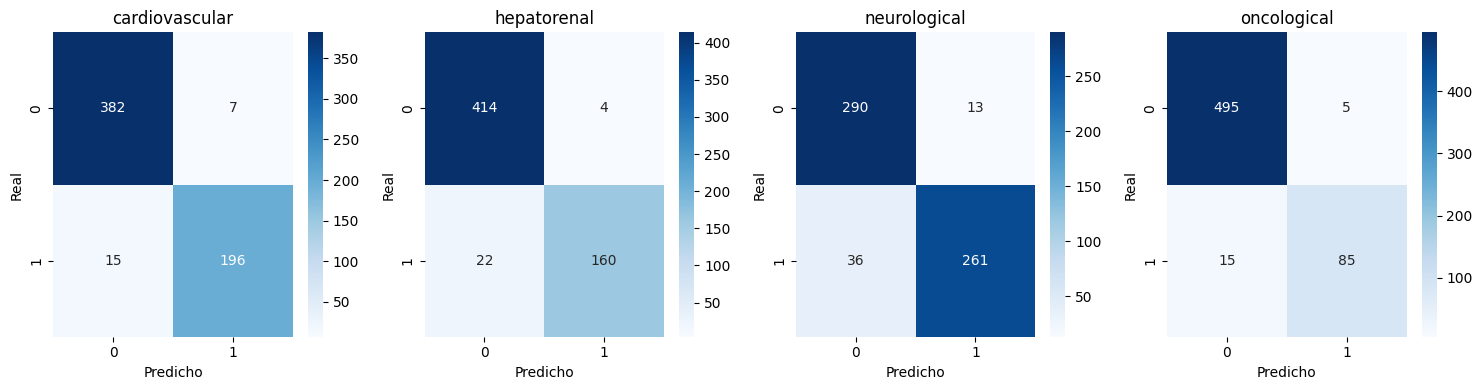

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reporte en TEST

# Predicciones en test
best_model.eval()
with torch.no_grad():
    encodings = tokenizer(
        df_test[TEXT_COL].tolist(),
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    logits = best_model(input_ids, attention_mask)
    probs = torch.sigmoid(logits).cpu().numpy()

y_test_pred = (probs >= 0.5).astype(int)

# Reporte por clase
print("Classification Report")
print(classification_report(Y_test, y_test_pred, target_names=label_cols, digits=3))

# Matrices de confusión multilabel

mcm = multilabel_confusion_matrix(Y_test, y_test_pred)

fig, axes = plt.subplots(1, len(label_cols), figsize=(15,4))
for i, (label, matrix) in enumerate(zip(label_cols, mcm)):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(label)
    axes[i].set_xlabel("Predicho")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.show()


In [ ]:

# Optimización de thresholds por clase (VALID)

from sklearn.metrics import f1_score
import numpy as np
import json

# Obtener probabilidades en VALID
best_model.eval()
with torch.no_grad():
    encodings = tokenizer(
        df_valid[TEXT_COL].tolist(),
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    logits = best_model(input_ids, attention_mask)
    y_valid_probs = torch.sigmoid(logits).cpu().numpy()

# Buscar threshold óptimo por clase
best_thresholds = {}
for i, label in enumerate(label_cols):
    best_f1, best_th = 0, 0.5
    for th in np.linspace(0.1, 0.9, 17):  # barrido cada 0.05
        y_pred_temp = (y_valid_probs[:, i] >= th).astype(int)
        f1 = f1_score(Y_valid[:, i], y_pred_temp)
        if f1 > best_f1:
            best_f1, best_th = f1, th
    best_thresholds[label] = float(best_th)
    print(f"{label}: mejor threshold = {best_th:.2f} (F1={best_f1:.3f})")

# Guardar thresholds en JSON
thresholds_path = BASELINE_DIR / "best_thresholds.json"
with open(thresholds_path, "w", encoding="utf-8") as f:
    json.dump(best_thresholds, f, indent=2)

print("\nThresholds optimizados:", best_thresholds)
print(f"Guardados en: {thresholds_path}")


cardiovascular: mejor threshold = 0.30 (F1=0.950)
hepatorenal: mejor threshold = 0.40 (F1=0.963)
neurological: mejor threshold = 0.40 (F1=0.906)
oncological: mejor threshold = 0.40 (F1=0.933)

Thresholds optimizados: {'cardiovascular': 0.30000000000000004, 'hepatorenal': 0.4, 'neurological': 0.4, 'oncological': 0.4}
Guardados en: /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/best_thresholds.json


In [ ]:

# Evaluación en TEST con thresholds optimizados

from sklearn.metrics import classification_report, f1_score, average_precision_score, roc_auc_score

# Obtener probabilidades en TEST
best_model.eval()
with torch.no_grad():
    encodings = tokenizer(
        df_test[TEXT_COL].tolist(),
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    logits = best_model(input_ids, attention_mask)
    y_test_probs = torch.sigmoid(logits).cpu().numpy()

# Cargar thresholds desde JSON (para la API)
import json
with open(BASELINE_DIR / "best_thresholds.json", "r", encoding="utf-8") as f:
    best_thresholds = json.load(f)

# Predicciones usando thresholds optimizados
y_test_pred = np.zeros_like(Y_test)
for i, label in enumerate(label_cols):
    th = best_thresholds[label]
    y_test_pred[:, i] = (y_test_probs[:, i] >= th).astype(int)

# Métricas globales
f1_micro = f1_score(Y_test, y_test_pred, average="micro")
ap_micro = average_precision_score(Y_test, y_test_probs, average="micro")
roc_micro = roc_auc_score(Y_test, y_test_probs, average="micro")

print("Resultados en TEST (Fine-tuned + thresholds por clase)")
print(f"F1 (micro): {f1_micro:.4f}")
print(f"AP (micro): {ap_micro:.4f}")
print(f"ROC-AUC (micro): {roc_micro:.4f}")

# Reporte detallado por clase
print("\nReporte detallado por clase:")
print(classification_report(Y_test, y_test_pred, target_names=label_cols, digits=3))


Resultados en TEST (Fine-tuned + thresholds por clase)
F1 (micro): 0.9300
AP (micro): 0.9722
ROC-AUC (micro): 0.9807

Reporte detallado por clase:
                precision    recall  f1-score   support

cardiovascular      0.962     0.953     0.957       211
   hepatorenal      0.976     0.890     0.931       182
  neurological      0.944     0.902     0.923       297
   oncological      0.925     0.860     0.891       100

     micro avg      0.953     0.908     0.930       790
     macro avg      0.952     0.901     0.925       790
  weighted avg      0.954     0.908     0.930       790
   samples avg      0.964     0.937     0.940       790



In [ ]:
# Guardado del modelo fine-tuned + tokenizer + thresholds optimizados

import json
from pathlib import Path
import torch

# Carpeta donde guardaremos todo
save_dir = BASELINE_DIR / "bioclinicalbert_finetuned_final"
save_dir.mkdir(parents=True, exist_ok=True)

# 1. Guardar pesos del modelo fine-tuned
model_path = save_dir / "pytorch_model.bin"
torch.save(best_model.state_dict(), model_path)

# 2. Guardar el tokenizer
tokenizer.save_pretrained(save_dir)

# 3. Guardar thresholds optimizados (conversión np.float64 -> float)
thresholds_path = save_dir / "best_thresholds.json"
best_thresholds_clean = {k: float(v) for k, v in best_thresholds.items()}
with open(thresholds_path, "w", encoding="utf-8") as f:
    json.dump(best_thresholds_clean, f, indent=2)

print("Artefactos guardados:")
print(f"Modelo fine-tuned en: {model_path}")
print(f"Tokenizer en: {save_dir}")
print(f"Thresholds en: {thresholds_path}")


Artefactos guardados:
Modelo fine-tuned en: /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned_final/pytorch_model.bin
Tokenizer en: /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned_final
Thresholds en: /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned_final/best_thresholds.json


In [ ]:
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer

# 1. Reconstruir modelo temporal con la clase especifica
bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
tmp_model = BertForMultilabel(bert_model, num_labels=len(label_cols))
tmp_model.load_state_dict(torch.load(save_dir / "pytorch_model.bin", map_location="cpu"))

# 2. Crear un modelo Hugging Face equivalente
hf_model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    id2label={i: label for i, label in enumerate(label_cols)},
    label2id={label: i for i, label in enumerate(label_cols)},
)

# 3. Copiar los pesos del modelo temporal al modelo HF
hf_model.load_state_dict(tmp_model.state_dict())

# 4. Guardar en formato Hugging Face en la misma carpeta
hf_model.save_pretrained(save_dir)

# 5. Guardar también el tokenizer en la misma carpeta
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
tokenizer.save_pretrained(save_dir)

print("Modelo convertido y guardado en formato Hugging Face:", save_dir)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo convertido y guardado en formato Hugging Face: /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned_final


In [ ]:
# Inferencia con modelo fine-tuned + thresholds optimizados, ejemplo práctico para tantear

import torch
import numpy as np
import pandas as pd
import json
from pathlib import Path

# Ruta donde guardaste los artefactos
load_dir = BASELINE_DIR / "bioclinicalbert_finetuned_final"

# 1. Cargar modelo (misma clase que definimos antes)
best_model = BertForMultilabel(bert_model, num_labels)
best_model.load_state_dict(torch.load(load_dir / "pytorch_model.bin", map_location=device))
best_model = best_model.to(device)
best_model.eval()

# 2. Cargar tokenizer
tokenizer = AutoTokenizer.from_pretrained(load_dir)

# 3. Cargar thresholds optimizados
with open(load_dir / "best_thresholds.json", "r", encoding="utf-8") as f:
    best_thresholds = json.load(f)

print("Artefactos cargados para inferencia")

ejemplo = [
    """Patient presents with chest pain and shortness of breath.
    ECG shows ST elevation in leads II, III, and aVF.
    Troponin levels are elevated.
    Coronary angiography reveals 90% occlusion of the right coronary artery."""
]

# Tokenizar
enc = tokenizer(
    ejemplo,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
).to(device)

# Forward pass
with torch.no_grad():
    logits = best_model(enc["input_ids"], enc["attention_mask"])
    probs = torch.sigmoid(logits).cpu().numpy()[0]

# Aplicar thresholds optimizados
y_pred = (probs >= [best_thresholds[l] for l in label_cols]).astype(int)

# Armar dataframe con resultados
pred_df = pd.DataFrame({
    "label": label_cols,
    "predicted": y_pred,
    "score": probs
})

print("Resultados del abstract clínico (con thresholds optimizados):")
display(pred_df)


NameError: name 'BASELINE_DIR' is not defined

In [ ]:
# guardar todos los archivos del modelo para api
import torch, json
from pathlib import Path

save_dir = BASELINE_DIR / "bioclinicalbert_finetuned_torch"
save_dir.mkdir(parents=True, exist_ok=True)

# Guardar solo los pesos (state_dict) del modelo
torch.save(best_model.state_dict(), save_dir / "pytorch_model.bin")

# Guardar tokenizer
tokenizer.save_pretrained(save_dir)

# Guardar thresholds (conversión np.float64 → float por seguridad)
best_thresholds_clean = {k: float(v) for k, v in best_thresholds.items()}
with open(save_dir / "best_thresholds.json", "w", encoding="utf-8") as f:
    json.dump(best_thresholds_clean, f, indent=2)

print("Artefactos guardados en:", save_dir)


Artefactos guardados en: /content/drive/MyDrive/AI-DATA-CHALLENGE2/models/baseline/bioclinicalbert_finetuned_torch


In [ ]:
import torch, json
import pandas as pd
from transformers import AutoTokenizer

# Ruta de carga
load_dir = BASELINE_DIR / "bioclinicalbert_finetuned_torch"

# Reconstruir el modelo con la misma clase
best_model = BertForMultilabel(bert_model, num_labels)
state_dict = torch.load(load_dir / "pytorch_model.bin", map_location=device)
best_model.load_state_dict(state_dict)
best_model = best_model.to(device)
best_model.eval()

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(load_dir)

# Thresholds
with open(load_dir / "best_thresholds.json", "r", encoding="utf-8") as f:
    best_thresholds = json.load(f)

print("Modelo, tokenizer y thresholds cargados correctamente")

# Ejemplo de validación
ejemplo = [
    """Patient presents with chest pain and shortness of breath.
    ECG shows ST elevation in leads II, III, and aVF.
    Troponin levels are elevated.
    Coronary angiography reveals 90% occlusion of the right coronary artery."""
]

# Tokenizar
enc = tokenizer(
    ejemplo,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
).to(device)

# Forward
with torch.no_grad():
    logits = best_model(enc["input_ids"], enc["attention_mask"])
    probs = torch.sigmoid(logits).cpu().numpy()[0]

# Aplicar thresholds
y_pred = (probs >= [best_thresholds[l] for l in label_cols]).astype(int)

# Mostrar resultados
pred_df = pd.DataFrame({
    "label": label_cols,
    "predicted": y_pred,
    "score": probs
})

print("Resultados de validación:")
display(pred_df)


Modelo, tokenizer y thresholds cargados correctamente
Resultados de validación:


,label,predicted,score
0,cardiovascular,1,0.988726
1,hepatorenal,0,0.064446
2,neurological,0,0.144663
3,oncological,0,0.039390


In [ ]:
from transformers import AutoTokenizer

# Guardar el modelo y tokenizer en formato Hugging Face
save_dir = "./bioclinicalbert_finetuned_final_hf"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


AttributeError: 'BertForMultilabel' object has no attribute 'save_pretrained'

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch, json

# Nuevo directorio para guardar
save_dir = BASELINE_DIR / "bioclinicalbert_finetuned_final_hf"
save_dir.mkdir(parents=True, exist_ok=True)

# 1. Crear modelo Hugging Face equivalente
hf_model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=len(label_cols)
)

# 2. Copiar pesos entrenados
hf_model.load_state_dict(best_model.state_dict())

# 3. Guardar en formato Hugging Face
hf_model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

# 4. Guardar thresholds optimizados
with open(save_dir / "best_thresholds.json", "w", encoding="utf-8") as f:
    json.dump({k: float(v) for k, v in best_thresholds.items()}, f, indent=2)

print(f"Modelo convertido y guardado en {save_dir}")


In [ ]:
import torch, json
from pathlib import Path

# Ruta donde guardarás los artefactos
save_dir = BASELINE_DIR / "bioclinicalbert_finetuned_torch"
save_dir.mkdir(parents=True, exist_ok=True)

# Guardar solo los pesos (state_dict) del modelo
torch.save(best_model.state_dict(), save_dir / "pytorch_model.bin")

# Guardar tokenizer
tokenizer.save_pretrained(save_dir)

# Guardar thresholds (conversión np.float64 → float por seguridad)
best_thresholds_clean = {k: float(v) for k, v in best_thresholds.items()}
with open(save_dir / "best_thresholds.json", "w", encoding="utf-8") as f:
    json.dump(best_thresholds_clean, f, indent=2)

print("Artefactos guardados en:", save_dir)


In [ ]:
import torch
import json
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer

# Ruta al modelo que guardaste
load_dir = BASELINE_DIR / "bioclinicalbert_finetuned_torch"

# Definir arquitectura
class BertForMultilabel(torch.nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BertForMultilabel, self).__init__()
        self.bert = bert_model
        hidden_size = bert_model.config.hidden_size
        self.classifier = torch.nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS]
        logits = self.classifier(cls_output)
        return logits

# Configuración
label_cols = ["cardiovascular", "hepatorenal", "neurological", "oncological"]
num_labels = len(label_cols)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo base BERT
from transformers import AutoModel
bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Cargar tu modelo fine-tuned
best_model = BertForMultilabel(bert_model, num_labels)
state_dict = torch.load(load_dir / "pytorch_model.bin", map_location=device)
best_model.load_state_dict(state_dict)
best_model = best_model.to(device)
best_model.eval()

# Cargar tokenizer
tokenizer = AutoTokenizer.from_pretrained(load_dir)

# Cargar thresholds
with open(load_dir / "best_thresholds.json", "r", encoding="utf-8") as f:
    best_thresholds = json.load(f)

print("Modelo, tokenizer y thresholds cargados correctamente")

# Ejemplo clínico
ejemplo = [
    """Patient presents with chest pain and shortness of breath.
    ECG shows ST elevation in leads II, III, and aVF.
    Troponin levels are elevated.
    Coronary angiography reveals 90% occlusion of the right coronary artery."""
]

# Tokenización
enc = tokenizer(
    ejemplo,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
).to(device)

# Inferencia
with torch.no_grad():
    logits = best_model(enc["input_ids"], enc["attention_mask"])
    probs = torch.sigmoid(logits).cpu().numpy()[0]

# Aplicar thresholds optimizados
y_pred = (probs >= [best_thresholds[l] for l in label_cols]).astype(int)

# Mostrar resultados
pred_df = pd.DataFrame({
    "label": label_cols,
    "predicted": y_pred,
    "score": probs
})

print("Resultados del abstract clínico (con thresholds optimizados):")
display(pred_df)


In [ ]:
# -----------------------------------------------------------------------------
# NOTA: Lo siguiente son experimentos



In [ ]:
import torch
print("GPU disponible:", torch.cuda.is_available())


In [ ]:

# Embeddings con Bio_ClinicalBERT (title + abstract + text_norm)


!pip install transformers torch --quiet

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

TEXT_COL = "all_text"

# Concateno columnas de texto
for df_ in [df_train, df_valid, df_test]:
    df_.loc[:, TEXT_COL] = (
        df_["title"].fillna("") + " " +
        df_["abstract"].fillna("") + " " +
        df_["text_norm"].fillna("")
    )

# Asegurar que todo sea string y sin NaN
df_train[TEXT_COL] = df_train[TEXT_COL].astype(str).fillna("")
df_valid[TEXT_COL] = df_valid[TEXT_COL].astype(str).fillna("")
df_test[TEXT_COL]  = df_test[TEXT_COL].astype(str).fillna("")

# Modelo preentrenado Bio_ClinicalBERT
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

# GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)

def get_embeddings(texts, tokenizer, model, device, max_len=256):
    encoded = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    encoded = {k: v.to(device) for k, v in encoded.items()}
    with torch.no_grad():
        outputs = model(**encoded)
        # Tomamos [CLS] como embedding
        emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return emb

# Genero embeddings en batches para no quedarme sin memoria
X_train = np.vstack([
    get_embeddings(list(map(str, batch)), tokenizer, bert_model, device)
    for batch in np.array_split(df_train[TEXT_COL].tolist(), 10)
])

X_valid = np.vstack([
    get_embeddings(list(map(str, batch)), tokenizer, bert_model, device)
    for batch in np.array_split(df_valid[TEXT_COL].tolist(), 10)
])

X_test = np.vstack([
    get_embeddings(list(map(str, batch)), tokenizer, bert_model, device)
    for batch in np.array_split(df_test[TEXT_COL].tolist(), 10)
])

print("OK: Bio_ClinicalBERT embeddings listos →", X_train.shape)


In [ ]:

# Modelos baseline entrenados sobre embeddings de Bio_ClinicalBERT


base_models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, random_state=SEED, class_weight="balanced"
    ),
    "RidgeClassifier": RidgeClassifier(
        random_state=SEED, class_weight="balanced"
    ),
    "LinearSVC": CalibratedClassifierCV(
        estimator=LinearSVC(random_state=SEED, class_weight="balanced"),
        cv=3
    )
}

results = {}

for name, model in base_models.items():
    print(f"\nEntrenando {name} ...")
    clf = OneVsRestClassifier(model, n_jobs=-1)
    clf.fit(X_train, Y_train)

    # Evalúo en valid
    y_val_pred = clf.predict(X_valid)
    if hasattr(clf, "predict_proba"):
        y_val_prob = clf.predict_proba(X_valid)
    else:
        y_val_prob = clf.decision_function(X_valid)

    f1 = f1_score(Y_valid, y_val_pred, average="micro")
    ap = average_precision_score(Y_valid, y_val_prob, average="micro")
    roc = roc_auc_score(Y_valid, y_val_prob, average="micro")

    results[name] = {"f1": f1, "ap": ap, "roc": roc}
    print(f"{name} → F1: {f1:.4f} | AP: {ap:.4f} | ROC-AUC: {roc:.4f}")


In [ ]:

# Selección del mejor modelo y evaluación en test (con Bio_ClinicalBERT embeddings)


# Resultados en validación
df_results = pd.DataFrame(results).T.sort_values("f1", ascending=False)
print("Resultados en validación:")
display(df_results)

# Selecciono el mejor modelo según F1
best_model_name = df_results.index[0]
print(f"Mejor modelo según validación: {best_model_name}")

# Recupero el modelo correspondiente (con class_weight donde aplica)
if best_model_name == "LogisticRegression":
    best_model = LogisticRegression(max_iter=1000, random_state=SEED, class_weight="balanced")
elif best_model_name == "RidgeClassifier":
    best_model = RidgeClassifier(random_state=SEED, class_weight="balanced")
elif best_model_name == "ComplementNB":
    best_model = ComplementNB()
elif best_model_name == "LinearSVC":
    best_model = CalibratedClassifierCV(
        estimator=LinearSVC(random_state=SEED, class_weight="balanced"),
        cv=3
    )

# Reentreno con train + valid usando embeddings
X_train_full = np.vstack([X_train, X_valid])
Y_train_full = np.vstack([Y_train, Y_valid])

clf = OneVsRestClassifier(best_model, n_jobs=-1)
clf.fit(X_train_full, Y_train_full)

# Evalúo en test
y_test_pred = clf.predict(X_test)

if hasattr(clf, "predict_proba"):
    y_test_prob = clf.predict_proba(X_test)
else:
    y_test_prob = clf.decision_function(X_test)

f1 = f1_score(Y_test, y_test_pred, average="micro")
ap = average_precision_score(Y_test, y_test_prob, average="micro")
roc = roc_auc_score(Y_test, y_test_prob, average="micro")

print(f"Evaluación en TEST → F1: {f1:.4f} | AP: {ap:.4f} | ROC-AUC: {roc:.4f}")



In [ ]:
# Threshold tuning por clase

import numpy as np
from sklearn.metrics import f1_score

# Scores en validación (ya calculados antes)
if hasattr(clf, "predict_proba"):
    y_val_scores = clf.predict_proba(X_valid)
else:
    y_val_scores = clf.decision_function(X_valid)

# Umbrales candidatos
thresholds = np.linspace(0.1, 0.9, 9)

best_thresholds = {}
for i, label in enumerate(label_cols):
    best_f1 = -1
    best_t = 0.5
    for t in thresholds:
        preds = (y_val_scores[:, i] >= t).astype(int)
        f1 = f1_score(Y_valid[:, i], preds)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[label] = best_t
    print(f"{label}: mejor threshold = {best_t:.2f} (F1={best_f1:.3f})")

print("\nThresholds ajustados:", best_thresholds)


In [ ]:
# Guardado del modelo, Bio_ClinicalBERT y thresholds
import joblib
import json

# Paths donde guardar
model_path = BASELINE_DIR / f"{best_model_name}_BioClinicalBERT_model.joblib"
tokenizer_path = BASELINE_DIR / "bioclinicalbert_tokenizer"
bert_model_path = BASELINE_DIR / "bioclinicalbert_model"
thresholds_path = BASELINE_DIR / "best_thresholds.json"

# Guardar clasificador entrenado
joblib.dump(clf, model_path)

# Guardar tokenizer y modelo de BERT
tokenizer.save_pretrained(tokenizer_path)
bert_model.save_pretrained(bert_model_path)

# Guardar thresholds en JSON (convertir np.float64 → float nativo)
thresholds_clean = {k: float(v) for k, v in best_thresholds.items()}
with open(thresholds_path, "w", encoding="utf-8") as f:
    json.dump(thresholds_clean, f, indent=2)

print(f"Clasificador guardado en: {model_path}")
print(f"Tokenizer guardado en: {tokenizer_path}")
print(f"Modelo BERT guardado en: {bert_model_path}")
print(f"Thresholds guardados en: {thresholds_path}")




In [ ]:

# Prueba con un abstract clínico nuevo (ajuste manual de thresholds)


ejemplo = [
    """Patient presents with chest pain and shortness of breath.
    ECG shows ST elevation in leads II, III, and aVF.
    Troponin levels are elevated.
    Coronary angiography reveals 90% occlusion of the right coronary artery."""
]

# Genero embeddings con Bio_ClinicalBERT
X_new = get_embeddings(ejemplo, tokenizer, bert_model, device)

# Scores
if hasattr(clf, "predict_proba"):
    y_scores = clf.predict_proba(X_new)[0]
else:
    y_scores = clf.decision_function(X_new)[0]

# Copia de thresholds y ajuste manual
adjusted_thresholds = best_thresholds.copy()
adjusted_thresholds["neurological"] = 0.3  # más conservador

# Predicciones usando thresholds ajustados
y_pred = (y_scores >= [adjusted_thresholds[l] for l in label_cols]).astype(int)

# Armo dataframe con resultados
pred_df = pd.DataFrame({
    "label": label_cols,
    "predicted": y_pred,
    "score": y_scores
})

print("Resultados del abstract clínico con thresholds ajustados (neurological=0.7):")
display(pred_df)


In [ ]:

# Co-ocurrencias de etiquetas

# Conteo de ejemplos por combinación
combo_counts = df[label_cols].astype(int).groupby(label_cols).size().reset_index(name="count")

print("Combinaciones de etiquetas en el dataset:")
display(combo_counts.sort_values("count", ascending=False))

# En particular, ver cardiovascular + neurological
co_ocurr = df[(df["cardiovascular"] == 1) & (df["neurological"] == 1)]
print(f"Ejemplos con cardiovascular + neurological: {len(co_ocurr)}")
print(f"Porcentaje: {len(co_ocurr)/len(df):.2%}")

# Extra: matriz de co-ocurrencia
import seaborn as sns
import matplotlib.pyplot as plt

co_matrix = df[label_cols].T.dot(df[label_cols])  # producto matricial: co-ocurrencias
plt.figure(figsize=(6,5))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de co-ocurrencia de etiquetas")
plt.show()


In [ ]:
# ===============================
# Ensemble: LogisticRegression (embeddings BioBERT base) + Fine-tuned Bio_ClinicalBERT
# ===============================

def get_proba_from_lr(texts, tokenizer, bert_base_model, clf, device, max_len=256):
    """
    Genera embeddings estáticos con BioBERT base y predice probabilidades con LogisticRegression.
    """
    X_emb = np.vstack([
        get_embeddings(list(batch), tokenizer, bert_base_model, device, max_len=max_len)
        for batch in np.array_split(texts, 10)
    ])
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X_emb)
    else:
        return clf.decision_function(X_emb)


def get_proba_from_finetuned(texts, tokenizer, bert_finetuned, device, max_len=256):
    """
    Genera probabilidades directamente desde el modelo fine-tuned (Bio_ClinicalBERT).
    Tu clase BertForMultilabel devuelve directamente logits como Tensor.
    """
    bert_finetuned.eval()
    all_scores = []
    for batch in np.array_split(texts, 10):
        enc = tokenizer(
            list(batch),
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(device)

        # eliminar token_type_ids si existe
        if "token_type_ids" in enc:
            enc.pop("token_type_ids")

        with torch.no_grad():
            logits = bert_finetuned(**enc)  # devuelve directamente un tensor
            probs = torch.sigmoid(logits).cpu().numpy()
        all_scores.append(probs)

    return np.vstack(all_scores)


# ===============================
# Ensemble en VALID y TEST
# ===============================

alpha = 0.5  # peso para LogisticRegression (puedes tunearlo en valid)

# VALID
y_valid_scores_lr   = get_proba_from_lr(df_valid[TEXT_COL].tolist(), tokenizer, bert_model, clf, device)
y_valid_scores_bert = get_proba_from_finetuned(df_valid[TEXT_COL].tolist(), tokenizer, best_model, device)

y_valid_scores_ensemble = alpha * y_valid_scores_lr + (1 - alpha) * y_valid_scores_bert

# TEST
y_test_scores_lr   = get_proba_from_lr(df_test[TEXT_COL].tolist(), tokenizer, bert_model, clf, device)
y_test_scores_bert = get_proba_from_finetuned(df_test[TEXT_COL].tolist(), tokenizer, best_model, device)

y_test_scores_ensemble = alpha * y_test_scores_lr + (1 - alpha) * y_test_scores_bert

print("✅ Probabilidades combinadas (VALID + TEST) con ensemble listo")


In [ ]:
# ===============================
# Optimización de thresholds por clase en VALID
# ===============================
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score, classification_report

best_thresholds = {}
for i, label in enumerate(label_cols):
    best_f1 = 0
    best_th = 0.5
    for th in np.linspace(0.1, 0.9, 17):  # barrido cada 0.05
        y_pred_temp = (y_valid_scores_ensemble[:, i] >= th).astype(int)
        f1 = f1_score(Y_valid[:, i], y_pred_temp)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
    best_thresholds[label] = best_th
    print(f"{label}: mejor threshold = {best_th:.2f} (F1={best_f1:.3f})")

print("\nThresholds optimizados:", best_thresholds)

# ===============================
# Evaluación en TEST con thresholds optimizados
# ===============================

# Predicciones finales en TEST
y_test_pred = np.zeros_like(Y_test)
for i, label in enumerate(label_cols):
    y_test_pred[:, i] = (y_test_scores_ensemble[:, i] >= best_thresholds[label]).astype(int)

# Métricas globales
f1_micro = f1_score(Y_test, y_test_pred, average="micro")
ap_micro = average_precision_score(Y_test, y_test_scores_ensemble, average="micro")
roc_micro = roc_auc_score(Y_test, y_test_scores_ensemble, average="micro")

print("\n=== Resultados en TEST (Ensemble + thresholds por clase) ===")
print(f"F1 (micro): {f1_micro:.4f}")
print(f"AP (micro): {ap_micro:.4f}")
print(f"ROC-AUC (micro): {roc_micro:.4f}")

# Reporte detallado por clase
print("\nReporte detallado por clase:")
print(classification_report(Y_test, y_test_pred, target_names=label_cols, digits=3))


Emsamble de modelos

In [ ]:
# Probabilidades de cada modelo

# Baseline (TF-IDF + clasificador clásico)
y_valid_scores_baseline = clf.predict_proba(X_valid) if hasattr(clf, "predict_proba") else clf.decision_function(X_valid)
y_test_scores_baseline  = clf.predict_proba(X_test)  if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

# Bio_ClinicalBERT fine-tuned (best_model + tokenizer)
def get_proba_from_bert(texts, model, tokenizer, device, max_len=256):
    model.eval()
    all_scores = []
    for batch in np.array_split(texts, 10):  # dividir en batches para no quedarnos sin memoria
        enc = tokenizer(
            list(batch),
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        )
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)

        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()

        all_scores.append(probs)
    return np.vstack(all_scores)

y_valid_scores_bert = get_proba_from_bert(df_valid[TEXT_COL].tolist(), best_model, tokenizer, device)
y_test_scores_bert  = get_proba_from_bert(df_test[TEXT_COL].tolist(),  best_model, tokenizer, device)

print("OK: Probabilidades baseline y BioBERT generadas")


In [ ]:
# Ensemble (promedio ponderado de scores)

# Pesos para cada modelo
alpha = 0.7  # peso para BioBERT
beta  = 0.3  # peso para baseline TF-IDF

# Ensemble: combinación lineal de probabilidades
y_valid_scores_ensemble = alpha * y_valid_scores_bert + beta * y_valid_scores_baseline
y_test_scores_ensemble  = alpha * y_test_scores_bert  + beta * y_test_scores_baseline

# Predicciones binarias usando threshold estándar de 0.5
y_valid_pred = (y_valid_scores_ensemble >= 0.5).astype(int)
y_test_pred  = (y_test_scores_ensemble  >= 0.5).astype(int)

print("OK: Ensemble listo → probas y predicciones generadas")


In [ ]:

from sklearn.metrics import classification_report, f1_score, average_precision_score, roc_auc_score

print("Ensemble en VALIDACIÓN")
print(classification_report(Y_valid, y_valid_pred, target_names=label_cols, digits=3))

f1_val = f1_score(Y_valid, y_valid_pred, average="micro")
ap_val = average_precision_score(Y_valid, y_valid_scores_ensemble, average="micro")
roc_val = roc_auc_score(Y_valid, y_valid_scores_ensemble, average="micro")
print(f"VALID → F1: {f1_val:.4f} | AP: {ap_val:.4f} | ROC-AUC: {roc_val:.4f}\n")

print("Ensemble en TEST")
print(classification_report(Y_test, y_test_pred, target_names=label_cols, digits=3))

f1_test = f1_score(Y_test, y_test_pred, average="micro")
ap_test = average_precision_score(Y_test, y_test_scores_ensemble, average="micro")
roc_test = roc_auc_score(Y_test, y_test_scores_ensemble, average="micro")
print(f"TEST → F1: {f1_test:.4f} | AP: {ap_test:.4f} | ROC-AUC: {roc_test:.4f}")


In [ ]:
# Optimización de thresholds por clase
from sklearn.metrics import f1_score

best_thresholds = {}
for i, label in enumerate(label_cols):
    best_f1 = 0
    best_th = 0.5
    for th in np.linspace(0.1, 0.9, 17):  # barrido fino cada 0.05
        y_pred_temp = (y_valid_scores_ensemble[:, i] >= th).astype(int)
        f1 = f1_score(Y_valid[:, i], y_pred_temp)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
    best_thresholds[label] = best_th
    print(f"{label}: mejor threshold = {best_th:.2f} (F1={best_f1:.3f})")

print("\nThresholds ajustados:", best_thresholds)


In [ ]:
#Evaluación en TEST con thresholds ajustados

from sklearn.metrics import classification_report

y_test_pred_adj = np.zeros_like(y_test_scores_ensemble, dtype=int)

# aplicar el threshold específico de cada clase
for i, label in enumerate(label_cols):
    th = best_thresholds[label]
    y_test_pred_adj[:, i] = (y_test_scores_ensemble[:, i] >= th).astype(int)

print("Ensemble en TEST con thresholds ajustados")
print(classification_report(Y_test, y_test_pred_adj, target_names=label_cols, digits=3))


In [ ]:
# Guardar thresholds ajustados
import json

thresholds_path = BASELINE_DIR / "best_thresholds.json"
with open(thresholds_path, "w") as f:
    json.dump({k: float(v) for k, v in best_thresholds.items()}, f, indent=2)

print(f"Thresholds guardados en: {thresholds_path}")


In [ ]:
# Para asegurarme que todo este bien
print("Artefactos en memoria / disco:")
print("- vectorizer (TF-IDF):", 'vectorizer' in globals())
print("- clf (baseline):", 'clf' in globals())
print("- tokenizer (BioBERT):", 'tokenizer' in globals())
print("- best_model (fine-tuned):", 'best_model' in globals())

from pathlib import Path
print("\nEn disco:")
print("- tfidf_vectorizer.joblib:", (BASELINE_DIR/"tfidf_vectorizer.joblib").exists())
print("- baseline model .joblib :", any(BASELINE_DIR.glob("*_model.joblib")))
print("- bioclinicalbert_finetuned/pytorch_model.bin:",
      (BASELINE_DIR/"bioclinicalbert_finetuned"/"pytorch_model.bin").exists())
print("- best_thresholds.json:", (BASELINE_DIR/"best_thresholds.json").exists())
